In [3]:
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from keras.datasets import mnist
from sklearn.model_selection import train_test_split
warnings.filterwarnings("ignore")
import time

Using TensorFlow backend.


In [5]:
#mnist
from sklearn.datasets import fetch_openml
f_mnist = fetch_openml('Fashion-MNIST')
X, y = f_mnist["data"], f_mnist["target"]

X = X / 255


In [6]:
classes = 10
examples = y.shape[0]

y = y.reshape(1, examples)

Y_new = np.eye(classes)[y.astype('int32')]
Y_new = Y_new.T.reshape(classes, examples)

In [7]:

X_train, X_test, Y_train, Y_test = train_test_split(X, Y_new.T, test_size=0.2, random_state=42)
X_val, X_test, Y_val, Y_test = train_test_split(X_test, Y_test, test_size=0.5, random_state=42)

X_train=X_train.T
X_test=X_test.T
X_val = X_val.T

Y_train=Y_train.T
Y_test=Y_test.T
Y_val = Y_val.T

print(X_train.shape)
print(Y_train.shape)
print(X_val.shape)
print(Y_val.shape)
print(X_test.shape)
print(Y_test.shape)


(784, 56000)
(10, 56000)
(784, 7000)
(10, 7000)
(784, 7000)
(10, 7000)


In [8]:

def sigmoid(x):
    return 1. / (1.+np.exp(-x))
def dsigmoid(x):
    return sigmoid(x) * (1-sigmoid(x))

def Relu(x):
    return np.maximum(0,x)
def dRelu(x):
    return 1*(x>0) 

def tanh(x):
    return np.tanh(x)
def tanh_derivative(x):
    return (1 - (np.tanh(x)**2))

def softmax(x):
    return np.exp(x) / np.sum(np.exp(x), axis=0)

#cross-entropy for our cost function
def compute_multiclass_loss(Y, Y_hat):
    L_sum = np.sum(np.multiply(Y, np.log(Y_hat)))
    m = Y.shape[1]
    L = -(1/m) * L_sum
    return L

In [9]:
def initialise_parameters(layer_dims,init_mode):
    
    np.random.seed(42)
    params={}
    previous_updates = {}
    for i in range(1, len(layer_dims)):
        
        if init_mode == 'random_normal':
            params["W"+str(i)] = np.random.randn(layer_dims[i], layer_dims[i-1])
        elif init_mode == 'random_uniform':
            params["W"+str(i)] = np.random.rand(layer_dims[i], layer_dims[i-1])
        elif init_mode == 'xavier':
            params["W"+str(i)]= np.random.randn(layer_dims[i],layer_dims[i-1])*np.sqrt(2/(layer_dims[i]+layer_dims[i-1]))
            
        params["b"+str(i)] = np.zeros((layer_dims[i],1))
        
        previous_updates["W"+str(i)] = np.zeros((layer_dims[i], layer_dims[i-1]))
        previous_updates["b"+str(i)] = np.zeros((layer_dims[i], 1))

    
    return params,previous_updates
    

In [10]:
def forward_propagate(X,params,activation_f):
    L = len(params)//2 + 1
    A = [None]*L # activations
    Z = [None]*L # pre-activations
    
    A[0] = X
    
    for l in range(1, L):
        W = params["W"+str(l)]
        b = params["b"+str(l)]
        
        
        Z[l] = np.matmul(W,A[l-1]) + b
        
        
        if l == L-1:
            A[l] = softmax(Z[l]) # activation function for output layers
        else:
            if activation_f == 'sigmoid':
                A[l] = sigmoid(Z[l])
            elif activation_f == 'relu':
                A[l] = Relu(Z[l])
            elif activation_f == 'tanh':
                A[l] = tanh(Z[l])
                

    output = A[L-1]
    

    
    return output,A,Z

In [34]:
def backpropagate(y_hat,y,A,Z,params,activation_f):
    L = len(params)//2
    gradients = {}
    m=y.shape[1]
    
    gradients["dZ" + str(L)] = A[L]-y
    
    for l in range(L,0,-1):
        gradients["dW" + str(l)] = (1./m) * np.matmul(gradients["dZ" + str(l)], A[l-1].T)
        gradients["db" + str(l)] = (1./m) * np.sum(gradients["dZ" + str(l)], axis=1,keepdims=True)
        
        if l>1:
            if activation_f == 'sigmoid':
                gradients["dZ" + str(l-1)] = np.matmul(params["W" + str(l)].T, gradients["dZ" + str(l)]) * dsigmoid(Z[l-1])
            elif activation_f == 'relu':
                gradients["dZ" + str(l-1)] = np.matmul(params["W" + str(l)].T, gradients["dZ" + str(l)]) * dRelu(Z[l-1])
            elif activation_f == 'tanh':
                gradients["dZ" + str(l-1)] = np.matmul(params["W" + str(l)].T, gradients["dZ" + str(l)]) * dtanh(Z[l-1])
        
    return gradients
    

In [12]:
def update_params_sgd(parameters,grads,learning_rate):
    L = len(parameters) // 2 
    
    for l in range(1, L + 1):
        parameters["W" + str(l)] = parameters["W" + str(l)] - learning_rate * grads["dW" + str(l)]
        parameters["b" + str(l)] = parameters["b" + str(l)] - learning_rate * grads["db" + str(l)]

    return parameters

def update_parameters_momentum(parameters, grads, learning_rate, beta, previous_updates):
    L = len(parameters) // 2 # number of layers in the neural network

    for l in range(1, L + 1):
        previous_updates["W"+str(l)] = beta*previous_updates["W"+str(l)] + (1-beta)*grads["dW" + str(l)]
        parameters["W" + str(l)] = parameters["W" + str(l)] - learning_rate*previous_updates["W"+str(l)]
        
        previous_updates["b"+str(l)] = beta*previous_updates["b"+str(l)] + (1-beta)*grads["db" + str(l)]
        parameters["b" + str(l)] = parameters["b" + str(l)] - learning_rate*previous_updates["b"+str(l)]

    return parameters, previous_updates
    
def update_parameters_RMSprop(parameters, grads, learning_rate, beta, v):

    L = len(parameters) // 2 # number of layers in the neural network
    delta = 1e-6 #for numerical stability

    for l in range(1, L + 1):
        vdw = beta*v["W" + str(l)] + (1-beta)*np.multiply(grads["dW" + str(l)],grads["dW" + str(l)])
        vdb = beta*v["b" + str(l)] + (1-beta)*np.multiply(grads["db" + str(l)],grads["db" + str(l)])

        parameters["W" + str(l)] = parameters["W" + str(l)] - learning_rate * grads["dW" + str(l)] / (np.sqrt(vdw)+delta)
        parameters["b" + str(l)] = parameters["b" + str(l)] - learning_rate * grads["db" + str(l)] / (np.sqrt(vdb)+delta)

        v["W" + str(l)] = vdw
        v["b" + str(l)] = vdb

    return parameters,v

In [13]:
def plot_cost_curve(train_costs, val_costs):
    plt.plot(list(range(len(train_costs))), train_costs, 'r', label="Training loss")
    plt.plot(list(range(len(val_costs))), val_costs, 'lime', label="Validation loss")
    plt.title("Training and Validation vs Number of Epochs", size=16)
    plt.xlabel("Number of epochs", size=14)
    plt.ylabel("Loss", size=14)
    plt.grid()
    plt.legend()
    plt.show()

In [46]:
def NN_fit(X,y,X_val,y_val,layer_dims,learning_rate=0.01, activation_f='sigmoid', init_mode='xavier', optimizer = 'sgd', batch_size=512, epochs=100, beta=0.9):
    params,previous_updates = initialise_parameters(layer_dims,init_mode)
    
    epoch_cost = []
    validation_epoch_cost=[]
    prev_epoch_cost = 100000
    curr_epoch_cost =0
    params_look_ahead = params.copy()
    
    count = 1
    while abs(prev_epoch_cost-curr_epoch_cost) > 1e-7 and count<=epochs:
        
        count+=1
        
        for i in range(0, X.shape[1], batch_size):
            if optimizer == 'nesterov':
                
                L = len(params)//2
                for l in range(1,L+1):
                    params_look_ahead["W"+str(l)] = params["W"+str(l)] - beta*previous_updates["W"+str(l)]
                    params_look_ahead["b"+str(l)] = params["b"+str(l)] - beta*previous_updates["b"+str(l)]
                    
                output,A,Z = forward_propagate(X[:,i:i+batch_size],params_look_ahead,activation_f)
                gradients = backpropagate(output,y[:,i:i+batch_size],A,Z,params_look_ahead,activation_f)
                params,previous_updates = update_parameters_momentum(params, gradients, learning_rate, beta, previous_updates)
                
            else:
                output,A,Z = forward_propagate(X[:,i:i+batch_size],params,activation_f)

                gradients = backpropagate(output,y[:,i:i+batch_size],A,Z,params,activation_f)

                if optimizer == 'sgd':
                    params = update_params_sgd(params,gradients,learning_rate)
                if optimizer == 'momentum':
                    params,previous_updates = update_parameters_momentum(params, gradients, learning_rate, beta, previous_updates)
                if optimizer == 'RMSprop':
                    params,previous_updates = update_parameters_RMSprop(params, gradients, learning_rate, beta, previous_updates)
        
        cost = compute_multiclass_loss(y[:,i:i+batch_size], output)
        epoch_cost.append(cost)
        
        out, _, _ = forward_propagate(X_val, params, activation_f)
        val_cost = compute_multiclass_loss(y_val, out)
        validation_epoch_cost.append(val_cost)

        if (count % 2 == 0):
            print("Epoch", count, "cost: ", cost, "Validation cost:",val_cost)

    print("Final cost:", cost)
    
    plot_cost_curve(epoch_cost, validation_epoch_cost)
    
    return params, epoch_cost


In [41]:
def NN_predict(X_test,params,activation_f):
    output,_,_ = forward_propagate(X_test,params,activation_f)
    return output
    
def NN_evaluate(Y_hat,Y_test):
    predictions = np.argmax(Y_hat, axis=0)
    labels = np.argmax(Y_test, axis=0)
    print(classification_report(predictions, labels))
    

Epoch 2 cost:  0.7079821811977427 Validation cost: 0.6743875399697807
Epoch 4 cost:  0.5425088805363987 Validation cost: 0.5158686861946342
Epoch 6 cost:  0.469419937613917 Validation cost: 0.46383415987194815
Epoch 8 cost:  0.4175558443440715 Validation cost: 0.4358650586415125
Epoch 10 cost:  0.38122823203113043 Validation cost: 0.41672179318220387
Epoch 12 cost:  0.34526891869804555 Validation cost: 0.40243983951274176
Epoch 14 cost:  0.32012718401697726 Validation cost: 0.39107487351692716
Epoch 16 cost:  0.30347393901764497 Validation cost: 0.38184896876648783
Epoch 18 cost:  0.2913271754838289 Validation cost: 0.37399195207710983
Epoch 20 cost:  0.27930015512136996 Validation cost: 0.3671749828809574
Epoch 22 cost:  0.2657934027642821 Validation cost: 0.36143386989167187
Epoch 24 cost:  0.2554790179699695 Validation cost: 0.3561628745441641
Epoch 26 cost:  0.2444367090784129 Validation cost: 0.3513840662879548
Epoch 28 cost:  0.23591796986736285 Validation cost: 0.347548198957914

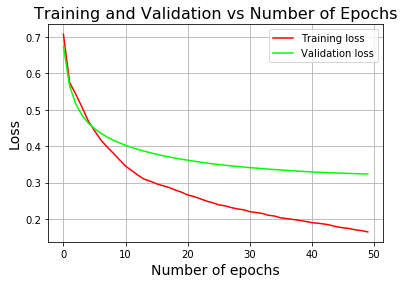

In [48]:
layer_dims= [X_train.shape[0],64,64,classes]
params,epoch_cost = NN_fit(X_train,Y_train,X_val,Y_val,layer_dims,0.1,'relu','xavier','nesterov',512,50)

In [49]:
from sklearn.metrics import classification_report

NN_evaluate(NN_predict(X_test,params,'relu'),Y_test)

              precision    recall  f1-score   support

           0       0.85      0.84      0.85       707
           1       0.97      0.99      0.98       712
           2       0.81      0.83      0.82       696
           3       0.90      0.89      0.90       731
           4       0.82      0.81      0.81       682
           5       0.97      0.97      0.97       744
           6       0.71      0.72      0.72       664
           7       0.96      0.95      0.95       694
           8       0.97      0.97      0.97       679
           9       0.95      0.95      0.95       691

    accuracy                           0.89      7000
   macro avg       0.89      0.89      0.89      7000
weighted avg       0.89      0.89      0.89      7000

